# Questions Per Language
This notebook intends to show how many stackoverflow questions exist for each programming language that has any considerable measure of use. 

# Step 0: Dependencies
This notebood expects you to already have the major python data science tools like numpy, pandas, and beautifulsoup. The author wrote it using anaconda, and it's recommneded that you use anaconda as well. Odds are if you have jupyter installed, you already have all the necessary tools.

# Step 1: Get a List of Programming Languages
We will use the [wikipedia page "list of programming languages"](https://en.wikipedia.org/wiki/List_of_programming_languages) as our major source. We will begin by downloading the HTML for that page and scraping it for names of programming languages.

In [1]:
WIKIPEDIA_LIST_OF_PROGRAMMING_LANGUAGES = 'https://en.wikipedia.org/wiki/List_of_programming_languages'

import requests
from bs4 import BeautifulSoup

with requests.get(WIKIPEDIA_LIST_OF_PROGRAMMING_LANGUAGES) as r:
    soup = BeautifulSoup(r.text, 'html.parser')

Once we have the data, we can scrape names of programming languages:

In [2]:
import re

content = soup.find('div', {'id': 'mw-content-text'})
sections = content.find_all('div', {'class': 'columns'})

sections_combined = sections[0]
for i in range(1, len(sections)):
    sections_combined.append(sections[i])

# in this case, the following two lines are equivalent:

#lis = sections_combined.findChildren('li')
lis = sections_combined.find_all('li')

programming_languages = []
for li in lis:
    # some languages had notes in parenthesis after their names. These were removed.
    programming_languages.append(re.sub(r'\(.*', '', li.text).strip())
    
# some languages had other extra text and had to be manually edited
programming_languages[programming_languages.index('App Inventor for Android\'s visual block language')] = 'App Inventor'
programming_languages[programming_languages.index('C – ISO/IEC 9899')] = 'C'
programming_languages[programming_languages.index('COBOL – ISO/IEC 1989')] = 'COBOL'
programming_languages[programming_languages.index('CobolScript – COBOL Scripting language')] = 'Cobolscript'
programming_languages[programming_languages.index('EusLisp Robot Programming Language')] = 'EusLisp'
programming_languages[programming_languages.index('Fortran – ISO/IEC 1539')] = 'Fortran'
programming_languages[programming_languages.index('Game Maker Language')] = 'GML'
programming_languages[programming_languages.index('MASM Microsoft Assembly x86')] = 'MASM'
programming_languages[programming_languages.index('MaxScript internal language 3D Studio Max')] = 'maxscript'
programming_languages[programming_languages.index('Not eXactly C')] = 'nxc'
programming_languages[programming_languages.index('PL/I – ISO 6160')] = 'PL/I'
programming_languages[programming_languages.index('PowerBuilder – 4GL GUI application generator from Sybase')] = 'PowerBuilder'
programming_languages[programming_languages.index('TMG, compiler-compiler')] = 'tmg'
programming_languages[programming_languages.index('WATFIV, WATFOR')] = 'WATFIV'

i = programming_languages.index('AutoLISP / Visual LISP')
programming_languages[i] = 'AutoLISP'
programming_languages.insert(i, 'Visual LISP')

programming_languages.append('.net-core')

# spaces were replaced with '-', as this seems to be the stackoverflow convention.
# for instance, the tag 'assemblylanguage' (stackoverflow removes whitespace) has
# 0 questions, but 'assembly-language' redirects to 'assembly', which has 35,579
# questions at the time of writing.

# additionally, 'commonlisp' has 0 questions, but 'common-lisp' has 5,368 questions
# at the time of writing

for i in range(len(programming_languages)):
    programming_languages[i] = programming_languages[i].replace(' ', '-')

# optionally, print and inspect the languages here
#print(programming_languages)

## Programming languages by category
Categorizing anything is difficult and often arbitrary. However, there are certain classes of languages the author is interested in, and so a few categories have been manually compiled below. Wikipedia has a page titled ["list of programming languages by type"](https://en.wikipedia.org/wiki/List_of_programming_languages_by_type) that was a frequent reference. However, the choice of languages to include was based entirely on the author's interests and opinions.

In [3]:
# some specific categories
pl_systems = ['ada', 'c', 'c++', 'd', 'nim', 'rust', 'swift']

pl_functional_pure = ['elm', 'haskell', 'purescript']
pl_functional_impure = ['elixir', 'erlang', 'lisp', 'ocaml', 'rust']
pl_functional_all = pl_functional_pure + pl_functional_impure

pl_concurrent = ['ballerina', 'clojure', 'eiffel', 'elixir', 'erlang', 'go']

pl_pure_oo = ['pharo', 'self', 'smalltalk']

# combine everything above without duplicates
pl_authors_interests = set(pl_systems + pl_functional_all + pl_concurrent + pl_pure_oo)

# some broader categories
pl_compiled = ['ada', 'ballerina', 'c', 'c++', 'c#', 'clojure', 'common-lisp', 
               'crystal', 'd', 'delphi', 'eiffel', 'elm', 'erlang', 'f#', 
               'fortran', 'go', 'groovy', 'haskell', 'java', 'julia', 'kotlin',
               'nim', 'objective-c', 'rust', 'scala', 'smalltalk', 'swift', 
               'ocaml']
pl_interpreted = ['javascript', 'lua', 'matlab', 'ocaml', 'php', 'python', 'r', 
                  'ruby', 'bash', ]


# Step 2: query serverfault for the number of questions having each tag

In [4]:
#### This cell access the internet ####
# scrapes stackexchange for searches with tags

import time
from multiprocessing import Process, Lock, Pool, Manager

STACKOVERFLOW_TAG_SEARCH_URL_BASE = 'https://stackoverflow.com/questions/tagged/'

# now in parallel! This doesn't actually speed up the code at all, because our
# bottleneck is stackoverflow. However, this ensures that if one request fails,
# we don't lose all the data we've already obtained. In long lists like this,
# this is important!
NUM_THREADS = 4

# time is in seconds. This should be at least 1.0 to avoid rate-limiting
TIME_BETWEEN_REQUESTS = 1.0
        
# regular expression for getting number from questions
re_num_questions = re.compile(r'(\d+,?)+' , re.MULTILINE)

def handle_so_tagged_url(pl, result_container, container_lock):
    with requests.get(STACKOVERFLOW_TAG_SEARCH_URL_BASE + pl) as r:
        if r.ok:
            ### create soup from webpage
            stackoverflow_soup = BeautifulSoup(r.text, 'html.parser')

            ### find div with number of questions
            questions_text = stackoverflow_soup.find('div', 
                {'class': 'fs-body3 grid--cell fl1 mr12 sm:mr0 sm:mb12'})
            num_questions_match = re_num_questions.search(questions_text.text)
            num_questions_string = num_questions_match.group(0).replace(',', '')
            num_questions = int(num_questions_string)
            #print(num_questions)

            ### find descripition
            description_container = stackoverflow_soup.find_all('div', {'class': 'mb24'})

            # we are operating under the assumption that the description is the *second* div with 
            # class mb24. THIS MAY CHANGE without notice. We are subject to the whims of 
            # stackexchange
            description_container = description_container[1]
            description = description_container.find('p').text
            description = description.replace('\r\n', ' ')
            description = description.replace('\n', ' ')
            description = description.strip()
            #print(description)

            ### put it all into a tuple that gets added to our list
            container_lock.acquire()
            try:
                result_container.append({
                    'tag': pl,
                    'num_questions': num_questions,
                    'description': description
                })
            finally:
                print('Successfully stored info for questions on tag \'', pl, '\'', sep='')
                container_lock.release()
                return (pl, num_questions, description)

        else:
            #print('Got status code ', r.status_code, ' while searching for questions with tag \'',
            #      pl, '\'', sep='')
            if(r.status_code == 429):
                print('This IP address has been rate-limited by stack exchange! Please '
                      + 'try again later. You may optionally increase the time between '
                      + 'requests by editing the variable \'TIME_BETWEEN_REQUESTS\'')
    return None

                
result_codes = []
pl_manager = Manager()
pl_stats_lock = pl_manager.Lock()
pl_stats = pl_manager.list()

with Pool(processes=NUM_THREADS) as pool:
    
    # the actual work we want to do
    for pl in programming_languages:
    
    # or, alternatively, some test cases to avoid running eveything
    #for pl in ['c', 'fakelang', 'c++', 'Pro*C', 'Pure', 'Pure-Data', 'PureScript', 'Python']:
    
        # stack exchange states that they throttles all IP addresses sending more than 30 
        # requests per second. While writing this notebook, I've been rate limited even
        # when sending only 5 requests per second. Therefore, we will wait a generous
        # amount of time between each request to avoid rate-limiting

        time.sleep(TIME_BETWEEN_REQUESTS)
        
        # do the work, asynchronously
        rc = pool.apply_async(handle_so_tagged_url, (pl, pl_stats, pl_stats_lock) )
        
        # we append a tuple with both the name of the language and the result, so if an
        # exception occurs then we know which language had the problem
        result_codes.append({ 
            'tag': pl, 
            'result': rc
        })
        
    # no more tasks allowed
    pool.close()
    # wait for child tasks to finish
    pool.join()


Successfully stored info for questions on tag 'ABAP'
Successfully stored info for questions on tag 'ABC'
Successfully stored info for questions on tag 'ACC'
Successfully stored info for questions on tag 'Accent'
Successfully stored info for questions on tag 'Action!'
Successfully stored info for questions on tag 'ActionScript'
Successfully stored info for questions on tag 'Actor'
Successfully stored info for questions on tag 'Ada'
Successfully stored info for questions on tag 'Agda'
Successfully stored info for questions on tag 'AIMMS'
Successfully stored info for questions on tag 'Alice'
Successfully stored info for questions on tag 'AMOS'
Successfully stored info for questions on tag 'AMPL'
Successfully stored info for questions on tag 'AngelScript'
Successfully stored info for questions on tag 'Apex'
Successfully stored info for questions on tag 'APL'
Successfully stored info for questions on tag 'App-Inventor'
Successfully stored info for questions on tag 'AppleScript'
Successfully

Successfully stored info for questions on tag 'K'
Successfully stored info for questions on tag 'Kaleidoscope'
Successfully stored info for questions on tag 'Karel'
Successfully stored info for questions on tag 'KIF'
Successfully stored info for questions on tag 'Kotlin'
Successfully stored info for questions on tag 'KRL'
Successfully stored info for questions on tag 'KRL'
Successfully stored info for questions on tag 'KRYPTON'
Successfully stored info for questions on tag 'Kv'
Successfully stored info for questions on tag 'LabVIEW'
Successfully stored info for questions on tag 'LANSA'
Successfully stored info for questions on tag 'Lava'
Successfully stored info for questions on tag 'Lean'
Successfully stored info for questions on tag 'LilyPond'
Successfully stored info for questions on tag 'Lingo'
Successfully stored info for questions on tag 'LINQ'
Successfully stored info for questions on tag 'LIS'
Successfully stored info for questions on tag 'Logtalk'
Successfully stored info for 

Successfully stored info for questions on tag 'Stateflow'
Successfully stored info for questions on tag 'Subtext'
Successfully stored info for questions on tag 'SuperCollider'
Successfully stored info for questions on tag 'Swift'
Successfully stored info for questions on tag 'Swift'
Successfully stored info for questions on tag 'TAL'
Successfully stored info for questions on tag 'Tcl'
Successfully stored info for questions on tag 'TECO'
Successfully stored info for questions on tag 'TeX'
Successfully stored info for questions on tag 'TEX'
Successfully stored info for questions on tag 'TIE'
Successfully stored info for questions on tag 'Tom'
Successfully stored info for questions on tag 'TPU'
Successfully stored info for questions on tag 'Trac'
Successfully stored info for questions on tag 'TTCN'
Successfully stored info for questions on tag 'Turing'
Successfully stored info for questions on tag 'TypeScript'
Successfully stored info for questions on tag 'Umple'
Successfully stored info 

## Inspecting the status of each request
If one of these requests has a problem, we should inspect this. Note that it is not strictly necessary to resolve all requests. The language may be malformed (for example, this is the case for 'Pro*C') or may not have any results on stackoverflow.

In [5]:
import traceback

for rc in result_codes:
    # this will not stop when it encounters return code that indicates a problem! For confirmation,
    # uncomment this print to see that everything gets displayed
    #print(rc['tag'])
    
    if not rc['result'].successful():
        print('The request corresponding to the language', rc['tag'],
              'had an exception! The error is printed below:')
        try:
            rc['result'].get()
        except Exception as e:
            # capture the exception and print it
            
            # e.__traceback__ seems to include a WHOLE BUNCH more info than we really need...
            #traceback.print_exception(Exception, e, e.__traceback__)     
            
            # this prints, but at the end of all the other prints... I presume it prints to stderr
            #traceback.print_exception(Exception, e, None)
            
            # alternatively to the current solution, print above could have used stderr:
            #print('stuff to print', file=sys.stderr)

            # this seems to do the trick!
            formatted_exception = traceback.format_exception(Exception, e, None)
            # remember that * unpacks a list
            print(*formatted_exception, sep='')
        
        print()

The request corresponding to the language Pro*C had an exception! The error is printed below:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/riley/.pyenv/versions/anaconda3-2020.07/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-4-0d36e4b028c2>", line 42, in handle_so_tagged_url
    description = description_container.find('p').text
AttributeError: 'NoneType' object has no attribute 'text'
"""

The above exception was the direct cause of the following exception:

AttributeError: 'NoneType' object has no attribute 'text'




# Step 3: Store data for later use
In case stack exchange decides to implement more aggressive rate-limiting or dramatically changes their website, it will be handy to have this data saved to disk. Since we're going to want to use something like pandas to analyze and visualize the data, it makes sense to just create a DataFrame here and use that to write a csv to disk.

In [6]:
DATA_DIRECTORY = 'data'
DATA_FILENAME = 'plang-data'

import datetime
import pandas
from pathlib import Path

# remember pl_stats is a fancy SyncManager list, so we have to convert it to a normal list
pl_df = pandas.DataFrame(list(pl_stats))

n = datetime.datetime.now();
output_filename = DATA_DIRECTORY + '/' + DATA_FILENAME + '_' + n.strftime('%Y-%m-%d_%H%M') + '.csv'

Path(DATA_DIRECTORY).mkdir(exist_ok=True)

with open(output_filename, 'w') as f:
    pl_df.to_csv(f, index=False)

## Optional: Load old data from CSV
If live data from serverfault isn't available, data may be loaded from a CSV by uncommenting lines 4 and 5 below.

In [7]:
# in case you haven't run cells before this one
import pandas 

try:
    pl_df
except NameError:
    print('pl_df is not defined, loading data from csv')
    with open('data/plang-data_2020-10-19_0017.csv', 'r') as f:
        pl_df = pandas.read_csv(f, header=0)
else:
    print('pl_df is already defined! Doing nothing to avoid overwriting data...')

pl_df is already defined! Doing nothing to avoid overwriting data...


# Step 4: Visualize data
Now the results of our work. What are the programming languages with the most questions asked?

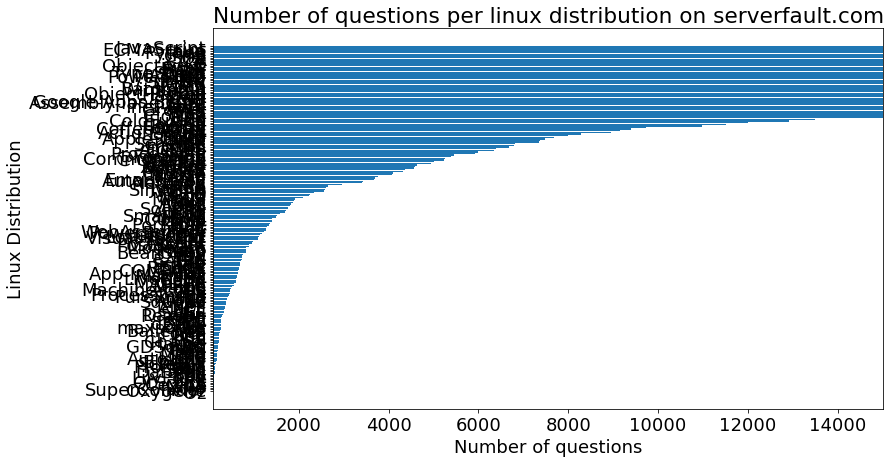

In [8]:
import matplotlib.pyplot as plt

# sorting data
pl_df.sort_values('num_questions', ascending=False, inplace=True)

# dropping any distro that has fewer than 100 questions on it
shortlist = pl_df[pl_df['num_questions'] > 100]

# data we want
names = shortlist['tag']
num_questions = shortlist['num_questions']

### plot data
# font size
plt.rcParams.update({'font.size': 18})

# figure
fig = plt.figure(figsize=(12, 7))

ax = plt.subplot()

# cosmetic
ax.set_ylabel('Linux Distribution')
ax.set_xlabel('Number of questions')
ax.set_title('Number of questions per linux distribution on serverfault.com')

# functional
ax.invert_yaxis()
#ax.set_xscale('log')
ax.set_xlim([100, 15000])

# create plot
ax.barh(names, num_questions)

plt.show()

# Conclusion